In [1]:
import pyrosm

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from pyproj import CRS, Transformer
from geopandas import GeoDataFrame
from shapely.geometry import Point
from shapely.geometry.multilinestring import MultiLineString

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
# reading osm file

osm_map = pyrosm.OSM("../beam_root/test/input/sf-light/r5/sflight_muni.osm.pbf")

osm_network = osm_map.get_network()
osm_network['str_id']=osm_network['id'].astype(str)
display(osm_network.head(2))

,access,bicycle,bridge,busway,cycleway,foot,footway,highway,junction,lanes,lit,maxspeed,motorcar,motor_vehicle,name,oneway,overtaking,psv,ref,service,segregated,sidewalk,smoothness,surface,tracktype,tunnel,width,id,timestamp,version,tags,osm_type,geometry,length,str_id
0,None,None,None,None,None,None,None,residential,None,None,None,None,None,None,Macondray Lane,None,None,None,None,None,None,None,None,None,None,None,None,5004035,1269675947,7,None,way,"MULTILINESTRING ((-122.41648 37.79905, -122.41...",75.0,5004035
1,None,None,None,None,None,None,None,residential,None,None,None,None,None,None,6th Street,None,None,None,None,None,None,None,None,None,None,None,None,7373728,1432195457,10,None,way,"MULTILINESTRING ((-122.40013 37.77428, -122.40...",98.0,7373728


In [6]:
# reading physsim network

dtype = { 'attributeOrigId': str }
out_network = pd.read_csv("../beam_root/output/sf-light/sf-light-0.5k__2023-06-15_16-11-49_obh/network.csv.gz", dtype=dtype)
out_network["str_id"] = out_network['attributeOrigId'].astype(str)
out_network["id"] = pd.to_numeric(out_network["str_id"], errors='coerce').fillna(0).astype('Int64')
out_network.head(3)

,linkId,linkLength,linkFreeSpeed,linkCapacity,numberOfLanes,linkModes,attributeOrigId,attributeOrigType,fromNodeId,toNodeId,fromLocationX,fromLocationY,toLocationX,toLocationY,str_id,id
0,0,75.065,11.175972,1000.0,1.0,car;walk;bike,5004035,residential,0,1,551370.872255,4.183680e+06,551296.615289,4.183668e+06,5004035,5004035
1,1,75.065,11.175972,1000.0,1.0,car;walk;bike,5004035,residential,1,0,551296.615289,4.183668e+06,551370.872255,4.183680e+06,5004035,5004035
2,10,146.110,12.517089,800.0,1.0,car;walk;bike,7448875,unclassified,8,9,553480.804065,4.180423e+06,553626.820226,4.180434e+06,7448875,7448875


In [7]:
# creating geopandas dataframe out of point locations from physsim network

crs_to = CRS.from_epsg(4326) # the lat lon CRS
crs_from = CRS.from_epsg(26910) # sf crs
transformer = Transformer.from_crs(crs_from, crs_to)

def out_row_to_geometry(df_row):
    (from_x, from_y) = transformer.transform(df_row['fromLocationX'], df_row['fromLocationY'])
    (to_x, to_y) = transformer.transform(df_row['toLocationX'], df_row['toLocationY'])
    mls = MultiLineString([[[from_y, from_x], [to_y, to_x]]])
    return mls
    
out_geometry = out_network.apply(out_row_to_geometry, axis=1)
display(out_geometry.head(2))

out_network = gpd.GeoDataFrame(out_network, crs={'init': 'epsg:4326'}, geometry=out_geometry)
out_network.head(2)

0    MULTILINESTRING ((-122.41648369999999 37.79905...
1    MULTILINESTRING ((-122.41732799999998 37.79894...
dtype: object

/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,linkId,linkLength,linkFreeSpeed,linkCapacity,numberOfLanes,linkModes,attributeOrigId,attributeOrigType,fromNodeId,toNodeId,fromLocationX,fromLocationY,toLocationX,toLocationY,str_id,id,geometry
0,0,75.065,11.175972,1000.0,1.0,car;walk;bike,5004035,residential,0,1,551370.872255,4.183680e+06,551296.615289,4.183668e+06,5004035,5004035,"MULTILINESTRING ((-122.41648 37.79905, -122.41..."
1,1,75.065,11.175972,1000.0,1.0,car;walk;bike,5004035,residential,1,0,551296.615289,4.183668e+06,551370.872255,4.183680e+06,5004035,5004035,"MULTILINESTRING ((-122.41733 37.79895, -122.41..."


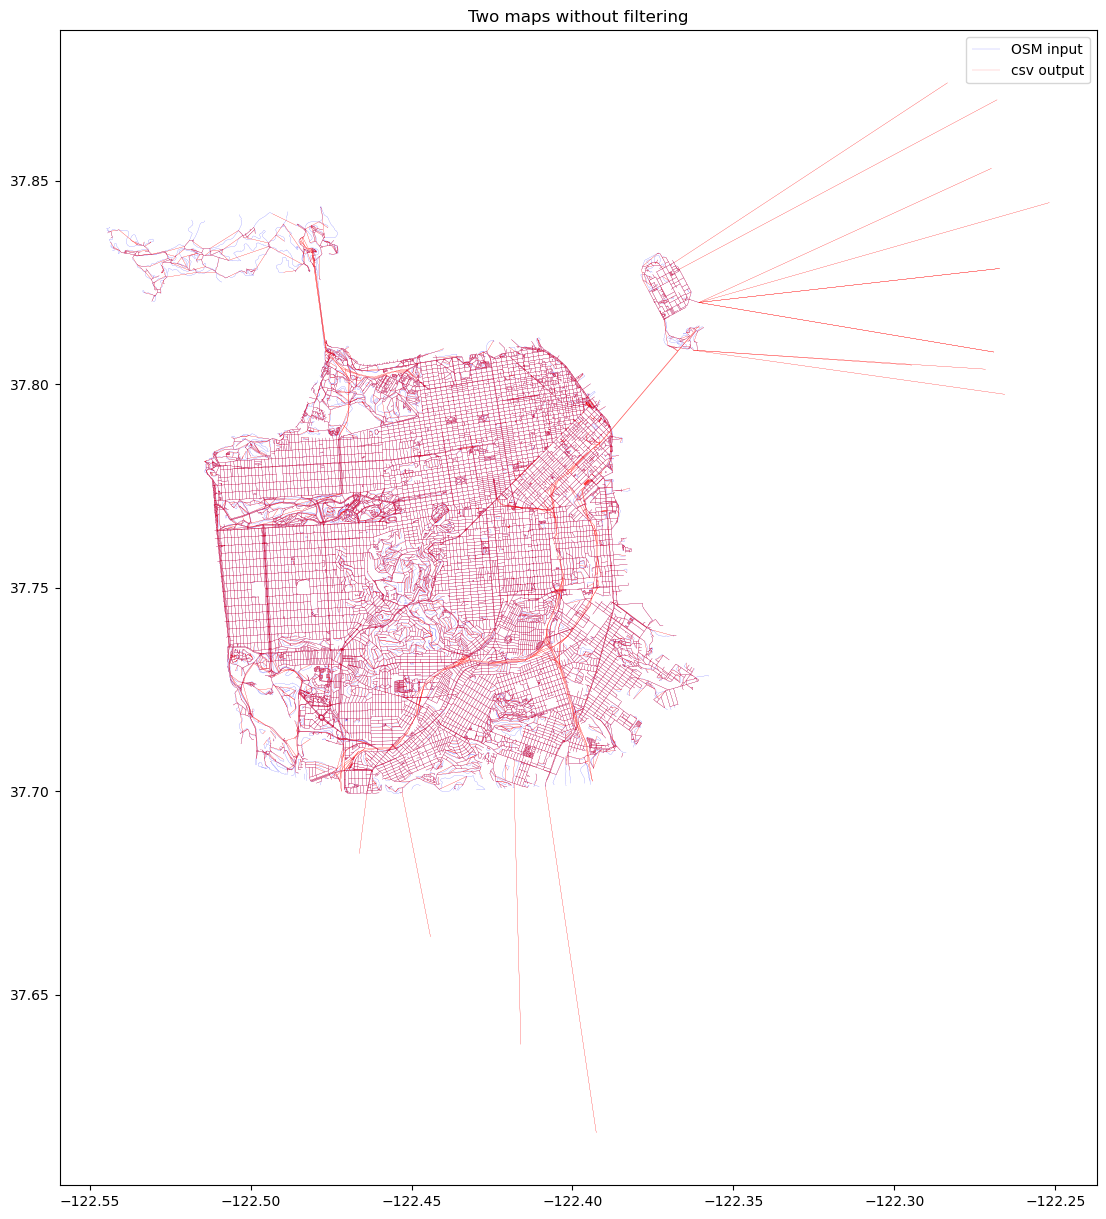

In [8]:
# plotting different networks on the same plot

fig, ax = plt.subplots(1,1, figsize=(15,15)) #, dpi=600)
osm_network.plot(lw=0.1, color='blue', label="OSM input", ax=ax)
out_network.plot(lw=0.1, color='red', label="csv output", ax=ax)

ax.set_title("Two maps without filtering")
ax.legend()
# fig.savefig("fig_full.png")

In [9]:
# analysis of IDs from both networks

osm_ids = set(osm_network['id'].unique())
out_ids = set(out_network['id'].unique())

print(len(osm_ids), "\t\t number of ID in input OSM network")
print(len(out_ids), "\t\t number of ID in output network")
print()
print(len(osm_network), f"\t\t the number of rows in input OSM network")
print(len(out_network), f"\t\t the number of rows in output network")
print("{:.6f}".format(len(out_network) / len(osm_network)), "\t out size / input size")
print()
print(len(osm_ids - out_ids), "\t\t number of ID that are in input OSM, but not in output") 
print(len(out_ids - osm_ids), "\t\t number of ID that are in output but not in input OSM")
print()
print(int(osm_network['length'].sum()), "\t total length of all entries in input OSM network")
print(int(out_network['linkLength'].sum()), "\t total length of all entries in output network")
print("{:.6f}".format(out_network['linkLength'].sum() / osm_network['length'].sum()), "\t out length / input length")

18036 		 number of ID in input OSM network
18734 		 number of ID in output network

18036 		 the number of rows in input OSM network
94348 		 the number of rows in output network
5.231093 	 out size / input size

86 		 number of ID that are in input OSM, but not in output
784 		 number of ID that are in output but not in input OSM

2627717 	 total length of all entries in input OSM network
5785011 	 total length of all entries in output network
2.201535 	 out length / input length


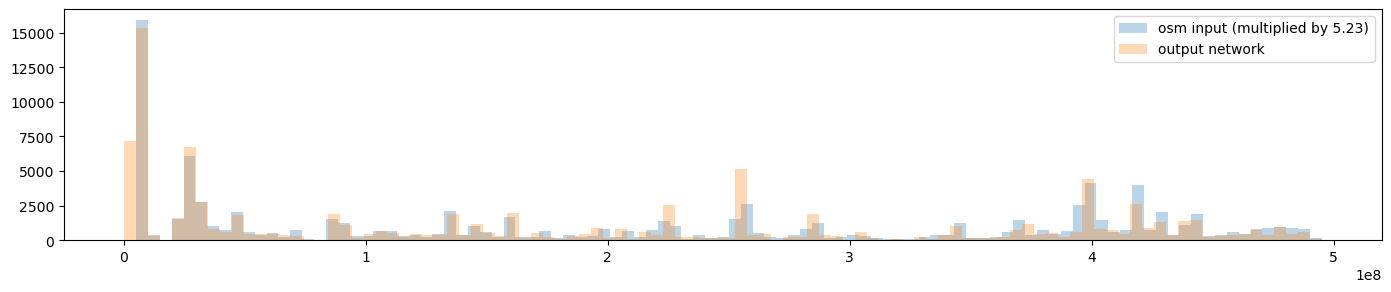

In [10]:
# analysis of lengths of OSM ids for both networks

nbins=100
alpha=0.3
fig, ax = plt.subplots(1, 1, figsize=(17, 3))
hist_ax = ax

factor=5.23
(osm_counts, osm_bins) = np.histogram(osm_network["id"], bins=nbins)
hist_ax.hist(osm_bins[:-1], bins=osm_bins, weights=factor*osm_counts, alpha=alpha, label=f"osm input (multiplied by {factor})")

factor=1.0
(out_counts, out_bins) = np.histogram(out_network["id"], bins=nbins)
hist_ax.hist(out_bins[:-1], bins=out_bins, weights=factor*out_counts, alpha=alpha, label=f"output network")

ax.legend()

7160 	 rows with OSM ID '0'
18733 	 total number of ID
9922 	 ids, each has 2 rows in output network per OSM ID
3978 	 ids, each has 4 rows in output network per OSM ID
1844 	 ids, each has 6 rows in output network per OSM ID
1008 	 ids, each has 8 rows in output network per OSM ID
571 	 ids, each has 10 rows in output network per OSM ID
400 	 ids, each has 12 rows in output network per OSM ID
241 	 ids, each has 14 rows in output network per OSM ID
170 	 ids, each has 16 rows in output network per OSM ID
128 	 ids, each has 18 rows in output network per OSM ID
112 	 ids, each has 20 rows in output network per OSM ID
71 	 ids, each has 22 rows in output network per OSM ID
288 	 ids, each has more than 22 rows in output network per OSM ID


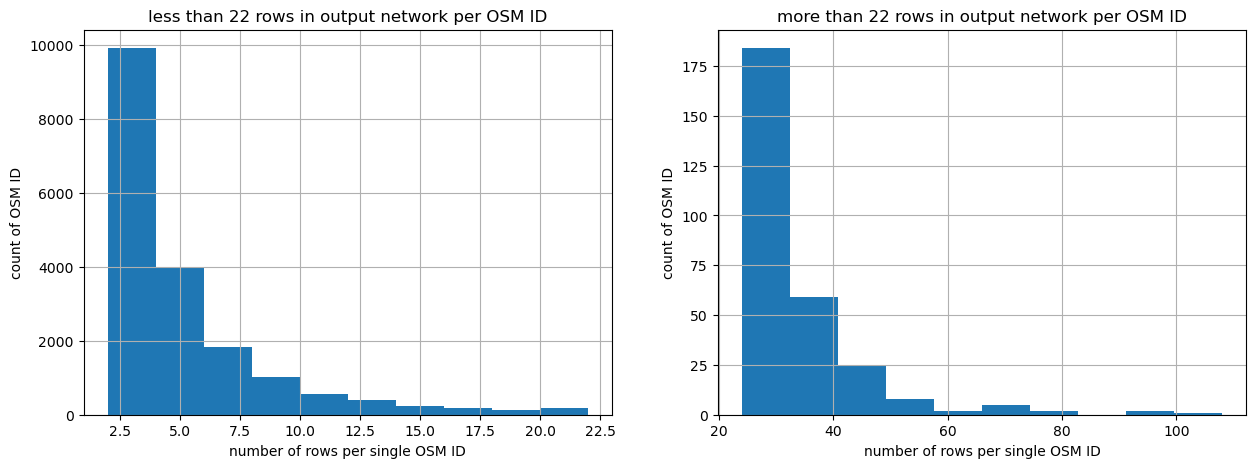

In [11]:
# analysis of amount of features in physsim network per each OSM ID

features_per_osm_id = out_network[out_network['id'] != 0].groupby("id")["str_id"].count().to_frame()
features_per_osm_id.rename(columns = {"str_id": "count"}, inplace=True)
print(len(out_network[out_network['id'] == 0]), "\t rows with OSM ID '0'")
print(len(features_per_osm_id), "\t total number of ID") 
# display(features_per_osm_id.head(2))

maxf=22
nf=0
for idx in range(2, maxf+1):
    nf = idx
    features_filtered = features_per_osm_id[features_per_osm_id['count'] == nf]
    if len(features_filtered) > 0:
        print(len(features_filtered), f"\t ids, each has {nf} rows in output network per OSM ID") 
        
print(len(features_per_osm_id[features_per_osm_id['count'] > maxf]), f"\t ids, each has more than {nf} rows in output network per OSM ID") 

fig, axs = plt.subplots(1, 2, figsize=(15,5))
features_per_osm_id[features_per_osm_id['count'] <= maxf]['count'].hist(ax=axs[0])
features_per_osm_id[features_per_osm_id['count'] > maxf]['count'].hist(ax=axs[1])

axs[0].set_title(f"less than {nf} rows in output network per OSM ID")
axs[1].set_title(f"more than {nf} rows in output network per OSM ID")

for ax in axs:
    ax.set_xlabel("number of rows per single OSM ID")
    ax.set_ylabel("count of OSM ID")

Text(0.5, 0, 'ratio [out len / input len] value')

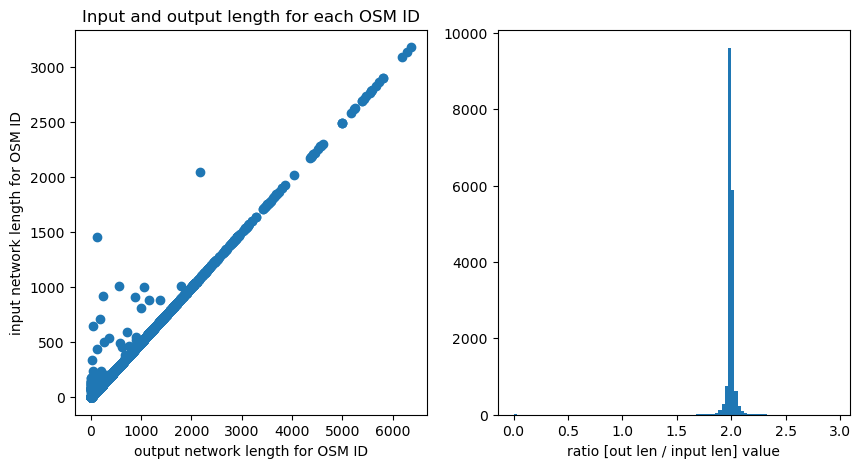

In [13]:
# analysis of lengths in both networks
# it is expected to have double the length in physsim network per each OSM ID from input network

osm_id_to_length = osm_network.groupby('id')["length"].sum().to_frame()
out_id_to_length = out_network.groupby('id')["linkLength"].sum().to_frame()

id_to_len = osm_id_to_length.join(out_id_to_length, how='inner').reset_index()
id_to_len.rename(columns={'length':'osm_len', 'linkLength':'out_len'}, inplace=True)
id_to_len['ratio'] = id_to_len["out_len"] / id_to_len["osm_len"]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(id_to_len['out_len'], id_to_len['osm_len'])
axs[0].set_title("Input and output length for each OSM ID")
axs[0].set_xlabel("output network length for OSM ID")
axs[0].set_ylabel("input network length for OSM ID")

axs[1].hist(id_to_len['ratio'], bins=100)
axs[1].set_xlabel("ratio [out len / input len] value")

In [14]:
# analysis of how many OSM ID there are with length to length ratio far from being equal to 2

left_value = 2.0 - 0.2
right_value = 2.0 + 0.2

osm_len_less = id_to_len[id_to_len['ratio'] > right_value]
osm_len_more_1 = id_to_len[id_to_len['ratio'] <= 1.0]
osm_len_more_2 = id_to_len[(id_to_len['ratio'] > 1.0) & (id_to_len['ratio'] < left_value)]
inside =  id_to_len[(left_value < id_to_len['ratio']) & (id_to_len['ratio'] < right_value)]

nodes_len_less = set(osm_len_less['id'].unique())
nodes_len_more_1 = set(osm_len_more_1['id'].unique())
nodes_len_more_2 = set(osm_len_more_2['id'].unique())

print(len(nodes_len_less), f"\t osm ID with length LESS than in output network [ratio > {right_value}]")
print(len(nodes_len_more_1) + len(nodes_len_more_2), f"\t osm ID with length MORE than in output network [ratio < {left_value}]")
print(len(inside), f"\t osm ID with {left_value} < ratio < {right_value}")

print(len(osm_id_to_length), len(osm_network), len(out_id_to_length), len(out_network), len(nodes_len_less) + len(nodes_len_more_1) + len(nodes_len_more_2) + len(inside) - len(id_to_len))

77 	 osm ID with length LESS than in output network [ratio > 2.2]
126 	 osm ID with length MORE than in output network [ratio < 1.8]
17747 	 osm ID with 1.8 < ratio < 2.2
18036 18036 18734 94348 0


In [15]:
ids_in_only_one_side = osm_ids.symmetric_difference(out_ids) - set([0])
len(ids_in_only_one_side)

869

/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


the len of filtered networks with 1 selected features: (OSM input, csv output): 0 7160


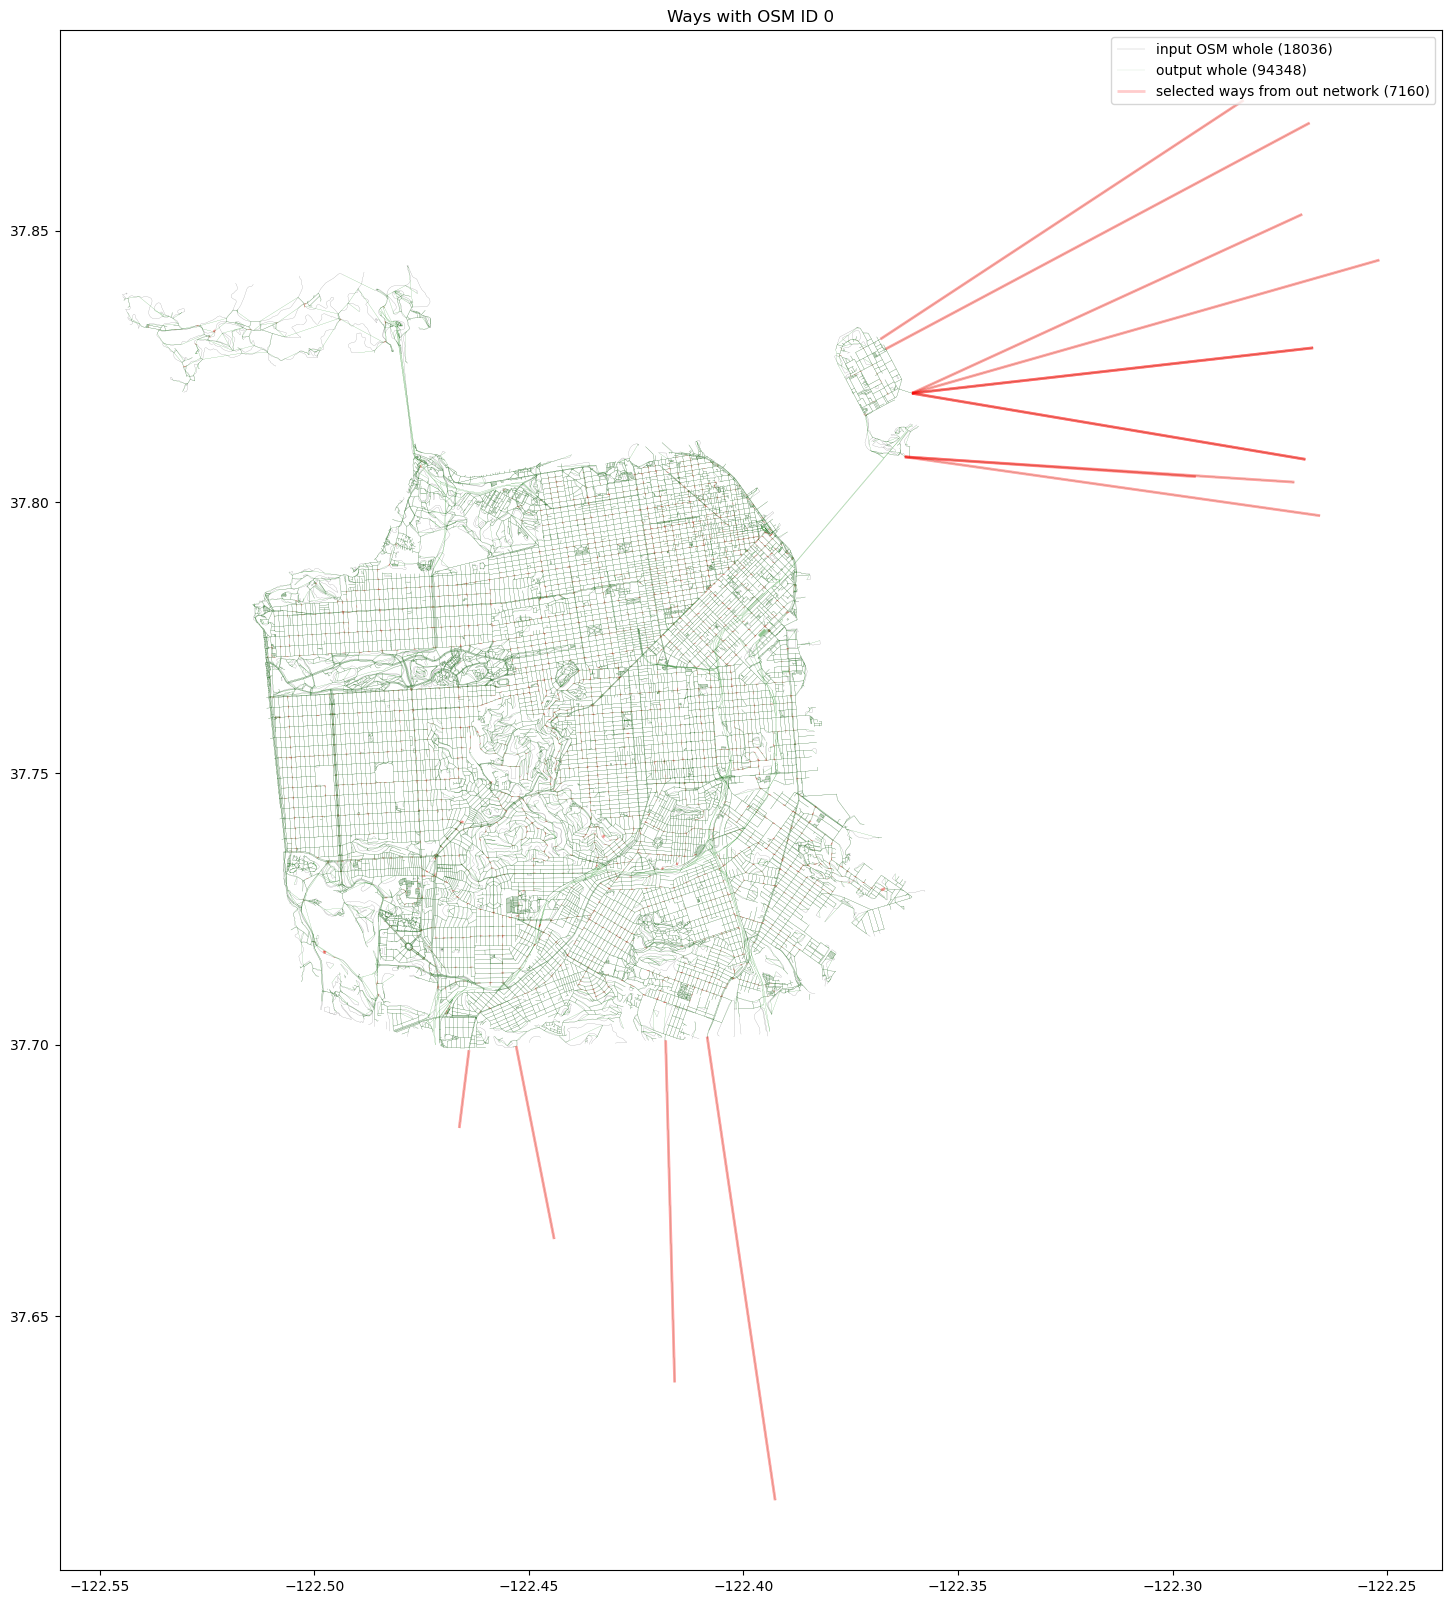

In [16]:
# plotting filtered out IDs

filter_set = set([0]) # ids_in_only_one_side # nodes_len_less.union(nodes_len_more_1).union(nodes_len_more_2)

fig, ax = plt.subplots(1,1, figsize=(20,20), dpi=100)

osm_network.plot(lw=0.15, color='gray', label=f"input OSM whole ({len(osm_network)})", ax=ax)
out_network.plot(lw=0.05, color='green', label=f"output whole ({len(out_network)})", ax=ax)

filtered_osm_network = osm_network[osm_network['id'].isin(filter_set)]
filtered_osm_network.plot(lw=2, color='blue', alpha=0.2,  label=f"selected ways from input OSM ({len(filtered_osm_network)})", ax=ax)

filtered_out_network = out_network[out_network['id'].isin(filter_set)]
filtered_out_network.plot(lw=2, color='red', alpha=0.2, label=f"selected ways from out network ({len(filtered_out_network)})", ax=ax)

ax.set_title("Ways with OSM ID 0")
ax.legend()
fig.savefig("ways_selected_1.png")

print(f"the len of filtered networks with {len(filter_set)} selected features: (OSM input, csv output):", len(filtered_osm_network), len(filtered_out_network))

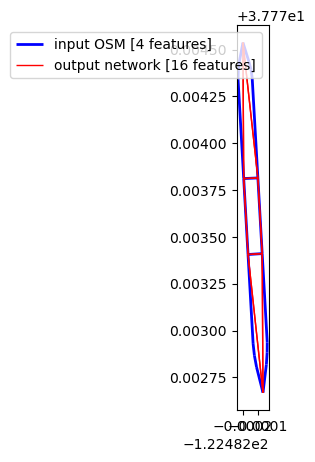

In [19]:
# plotting filtered out IDs

def filter_and_plot(ids):
    _, ax = plt.subplots(figsize=(5,5))
    
    osm_filtered = osm_network[osm_network['id'].isin(ids)]
    osm_filtered.plot(ax=ax, lw=2, color="blue", label=f"input OSM [{len(osm_filtered)} features]")
    
    out_filtered = out_network[out_network['id'].isin(ids)]
    out_filtered.plot(ax=ax, lw=1, color="red", label=f"output network [{len(out_filtered)} features]")
    
    ax.legend()
    
selected_ids_1 = set([8918622, 8919450, 86331230, 133856218, 158804462, 182668422, 182668423, 396954949, 437410671, 467991736, 467991737, 474114144])
selected_ids_2 = set([182668422, 182668423, 474114143, 474114144])
filter_and_plot(selected_ids_2)